## IEDA3302Final Project (Spring, 2022)

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, metrics, feature_extraction
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import time
from itertools import combinations
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


In [2]:
# Set display options
pd.options.display.max_rows, pd.options.display.max_columns = 30, 50

# Load Wayfair quarterly data, REVENUE is the total revenue, US is the revenue in the US, WORLD

wayfair_quarterly_data = pd.read_csv('Wayfair_quarterly_report.csv')
wayfair_quarterly_data.dtypes

DATE            object
REVENUE          int64
US               int64
WORLD          float64
ADVERTISING      int64
ACTIVE USER    float64
dtype: object

In [4]:
wayfair_quarterly_data

,DATE,REVENUE,US,WORLD,ADVERTISING,ACTIVE USER
0,1/1/2014,279,279,NaN,44,NaN
1,4/1/2014,295,295,NaN,43,NaN
2,7/1/2014,336,336,NaN,50,NaN
3,10/1/2014,409,409,NaN,55,NaN
4,1/1/2015,424,424,NaN,58,NaN
...,...,...,...,...,...,...
27,10/1/2020,3671,2999,672.0,374,31.2
28,1/1/2021,3478,2821,657.0,366,33.2
29,4/1/2021,3858,3098,760.0,352,31.1
30,7/1/2021,3121,2595,526.0,315,29.2


In [5]:
#Change the None data (those = 0)

WORLD_col = wayfair_quarterly_data['WORLD']
wayfair_quarterly_data[['WORLD', 'ACTIVE USER']] = wayfair_quarterly_data[['WORLD', 'ACTIVE USER']].fillna(wayfair_quarterly_data[['WORLD', 'ACTIVE USER']].mean())
wayfair_quarterly_data


,DATE,REVENUE,US,WORLD,ADVERTISING,ACTIVE USER
0,1/1/2014,279,279,328.0,44,19.745
1,4/1/2014,295,295,328.0,43,19.745
2,7/1/2014,336,336,328.0,50,19.745
3,10/1/2014,409,409,328.0,55,19.745
4,1/1/2015,424,424,328.0,58,19.745
...,...,...,...,...,...,...
27,10/1/2020,3671,2999,672.0,374,31.200
28,1/1/2021,3478,2821,657.0,366,33.200
29,4/1/2021,3858,3098,760.0,352,31.100
30,7/1/2021,3121,2595,526.0,315,29.200


In [157]:
external_indicators = pd.read_csv('external_indicators.csv')
external_indicators

,Date,PCE,Home_ownership,GDP,GDP_INDEX,GDP_real_INDEX,E_commerce_retail,E_commerce_retail_percent,Unemployment,Furniture_retail,Interest_rate
0,1/1/2014,1.6,64.8,4203940,103.106,100.394,70305,6.2,6.6,24173,0.07
1,4/1/2014,1.9,64.7,4360754,103.865,103.218,73329,6.3,6.2,25082,0.09
2,7/1/2014,1.9,64.4,4454942,104.000,105.507,75729,6.5,6.2,25339,0.09
3,10/1/2014,1.1,64.0,4531052,103.678,107.568,77649,6.6,5.7,25800,0.09
4,1/1/2015,-0.5,63.7,4389973,104.093,103.668,80228,6.9,5.7,25948,0.11
...,...,...,...,...,...,...,...,...,...,...,...
28,1/1/2021,1.5,65.6,5367754,115.920,113.974,215290,13.6,6.3,35983,0.09
29,4/1/2021,3.8,65.4,5711844,117.939,119.164,221951,13.3,6.1,36930,0.07
30,7/1/2021,6.5,65.4,5822816,119.400,120.122,214932,13.0,5.4,36411,0.10
31,10/1/2021,5.3,65.5,6121436,121.070,124.645,218533,12.9,4.6,36516,0.08


In [158]:
# Write down the list of features

features = ['PCE', 'Home_ownership', 'GDP', 'GDP_INDEX', 'GDP_real_INDEX',
         'E_commerce_retail', 'E_commerce_retail_percent', 'Unemployment',
         'Furniture_retail', 'Interest_rate']
features, external_indicators.columns #compare

(['PCE',
  'Home_ownership',
  'GDP',
  'GDP_INDEX',
  'GDP_real_INDEX',
  'E_commerce_retail',
  'E_commerce_retail_percent',
  'Unemployment',
  'Furniture_retail',
  'Interest_rate'],
 Index(['Date', 'PCE', 'Home_ownership', 'GDP', 'GDP_INDEX', 'GDP_real_INDEX',
        'E_commerce_retail', 'E_commerce_retail_percent', 'Unemployment',
        'Furniture_retail', 'Interest_rate'],
       dtype='object'))

In [159]:
# Write down the target
target = ['revenue']

In [160]:
data_combine = wayfair_quarterly_data.merge(external_indicators, left_on='DATE', right_on='Date')
data_combine

,DATE,REVENUE,US,WORLD,ADVERTISING,ACTIVE USER,Date,PCE,Home_ownership,GDP,GDP_INDEX,GDP_real_INDEX,E_commerce_retail,E_commerce_retail_percent,Unemployment,Furniture_retail,Interest_rate
0,1/1/2014,279,279,328.0,44,19.745,1/1/2014,1.6,64.8,4203940,103.106,100.394,70305,6.2,6.6,24173,0.07
1,4/1/2014,295,295,328.0,43,19.745,4/1/2014,1.9,64.7,4360754,103.865,103.218,73329,6.3,6.2,25082,0.09
2,7/1/2014,336,336,328.0,50,19.745,7/1/2014,1.9,64.4,4454942,104.000,105.507,75729,6.5,6.2,25339,0.09
3,10/1/2014,409,409,328.0,55,19.745,10/1/2014,1.1,64.0,4531052,103.678,107.568,77649,6.6,5.7,25800,0.09
4,1/1/2015,424,424,328.0,58,19.745,1/1/2015,-0.5,63.7,4389973,104.093,103.668,80228,6.9,5.7,25948,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,10/1/2020,3671,2999,672.0,374,31.200,10/1/2020,3.7,65.8,5490052,114.447,118.290,199794,13.6,6.9,32190,0.09
28,1/1/2021,3478,2821,657.0,366,33.200,1/1/2021,1.5,65.6,5367754,115.920,113.974,215290,13.6,6.3,35983,0.09
29,4/1/2021,3858,3098,760.0,352,31.100,4/1/2021,3.8,65.4,5711844,117.939,119.164,221951,13.3,6.1,36930,0.07
30,7/1/2021,3121,2595,526.0,315,29.200,7/1/2021,6.5,65.4,5822816,119.400,120.122,214932,13.0,5.4,36411,0.10


In [197]:

#drop_columns = ['DATE', 'ACTIVE USER', 'US', 'WORLD', 'GDP', 'GDP_INDEX', 'GDP_real_INDEX', 'Google_trend_0', 'Google_trend_1', 'Google_trend_2', 'Google_trend_3']
#data_all = data_combine.drop(columns = drop_columns)

#data_all = data_all.reindex(columns= ['REVENUE','ADVERTISING', 'Unemployment', 'Furniture_retail', 'PCE', 'Home_ownership', 'E_commerce_retail', 'E_commerce_retail_percent', 'Interest_rate'])
data_all = data_combine.reindex(columns= ['REVENUE','ACTIVE USER', 'US', 'WORLD', 'GDP_real_INDEX','ADVERTISING', 'Unemployment', 'Furniture_retail', 'PCE', 'Home_ownership', 'E_commerce_retail_percent', 'Interest_rate'])

#print(data_all)
data_train = data_all.loc[0:29, :]
#print(data_train)
data_test = data_all.loc[30:, :]
#print(data_test)
X_train = data_train.drop('REVENUE', axis = 1)
X_test = data_test.drop('REVENUE', axis = 1)
Y_train = data_train['REVENUE']
Y_test = data_test['REVENUE']
#X_train
#print(X_train)
#print(X_test)
#print(Y_train)
#print(Y_test)

    REVENUE  ADVERTISING  Unemployment  Furniture_retail  PCE  Home_ownership  \
30     3121          315           5.4             36411  6.5            65.4   
31     3252          345           4.6             36516  5.3            65.5   

    E_commerce_retail  E_commerce_retail_percent  Interest_rate  
30             214932                       13.0           0.10  
31             218533                       12.9           0.08  


In [162]:
# Import Linear regression model from Sklearn
multi_model = linear_model.LinearRegression()

In [163]:
# Train the model by using the first 30 quarters

X0 = X_train.values
Y0 = Y_train.values
X0, Y0 = shuffle(X0, Y0)
multi_model.fit(X0, Y0)

LinearRegression()

In [164]:
# Get values of the intercept and coefficients for the model

multi_model.intercept_, multi_model.coef_

(4553.135603068541,
 array([-1.76346386e+00,  1.05297014e+00, -3.26441168e-02,  6.39659751e-04,
        -3.54646133e+01, -2.67881427e+01,  6.74852559e-01,  2.73058894e-01,
        -1.53467375e-02,  7.79537636e+00, -9.50946691e+00,  8.87396570e-03,
        -8.99695826e+01, -2.86140795e+00]))

In [165]:
# Compare the predicted value of the training set after we train the model
multi_model.predict(X0), Y0

(array([ 288.06976491, 1387.39631164, 1635.58029483, 2541.96365988,
        3483.89552139, 1194.79961002, 2335.62456687, 3867.32912779,
         744.64228597,  417.13159436, 2340.38215679,  477.33647921,
         786.85703499, 1429.73197211,  774.29941909,  415.85232537,
         862.48962503, 3846.72987797, 4310.84006543,  267.14601007,
        1717.35791162,  332.32032936, 1135.35099972,  974.16046134,
        1997.01568363,  971.07750401, 3630.7221251 ,  618.19641777,
        2327.63896599, 1946.06189773]),
 array([ 295, 1404, 1655, 2533, 3478, 1198, 2305, 3858,  747,  424, 2330,
         492,  787, 1439,  740,  409,  862, 3840, 4305,  279, 1706,  336,
        1123,  985, 2014,  961, 3671,  594, 2343, 1945], dtype=int64))

In [166]:
# Now use the last two quarters for test

X1 = X_test.values
Y1 = Y_test.values
X1, Y1

(array([[2.920000e+01, 2.595000e+03, 5.260000e+02, 5.822816e+06,
         1.194000e+02, 1.201220e+02, 3.150000e+02, 5.400000e+00,
         3.641100e+04, 6.500000e+00, 6.540000e+01, 2.149320e+05,
         1.300000e+01, 1.000000e-01],
        [2.730000e+01, 2.735000e+03, 5.170000e+02, 6.121436e+06,
         1.210700e+02, 1.246450e+02, 3.450000e+02, 4.600000e+00,
         3.651600e+04, 5.300000e+00, 6.550000e+01, 2.185330e+05,
         1.290000e+01, 8.000000e-02]]),
 array([3121, 3252], dtype=int64))

In [167]:
# Make prediction for the test set and compare
# third quarter and fourth quarter
# actual performance is worse than predicted values

multi_model.predict(X1), Y1

(array([3310.65238878, 3521.45876837]), array([3121, 3252], dtype=int64))

### Best features prediction

In [168]:
def all_subsets(my_list):
    subs = []
    for i in range(1, len(my_list) + 1):
        subs += combinations(my_list, i)
    subset_List = []
    for i in subs:
        subset_List += [list(i)]
    return subset_List

In [196]:
features_numerical = list(data_all.select_dtypes(['int64', 'float64']).columns)
features_numerical.remove('REVENUE')
print(features_numerical)
features_categorical = list(data_all.select_dtypes(['object']).columns)
#print(features_categorical)
features = features_categorical + features_numerical
#target = ['REVENUE']
data = data_all[features_numerical + features_categorical + target]
data

['ADVERTISING', 'Unemployment', 'Furniture_retail', 'PCE', 'Home_ownership', 'E_commerce_retail', 'E_commerce_retail_percent', 'Interest_rate']


,ADVERTISING,Unemployment,Furniture_retail,PCE,Home_ownership,E_commerce_retail,E_commerce_retail_percent,Interest_rate,REVENUE
0,44,6.6,24173,1.6,64.8,70305,6.2,0.07,279
1,43,6.2,25082,1.9,64.7,73329,6.3,0.09,295
2,50,6.2,25339,1.9,64.4,75729,6.5,0.09,336
3,55,5.7,25800,1.1,64.0,77649,6.6,0.09,409
4,58,5.7,25948,-0.5,63.7,80228,6.9,0.11,424
...,...,...,...,...,...,...,...,...,...
27,374,6.9,32190,3.7,65.8,199794,13.6,0.09,3671
28,366,6.3,35983,1.5,65.6,215290,13.6,0.09,3478
29,352,6.1,36930,3.8,65.4,221951,13.3,0.07,3858
30,315,5.4,36411,6.5,65.4,214932,13.0,0.10,3121


In [171]:
def onehot_encoder(df, feature):
    result = pd.DataFrame()
    if feature in df.columns:
        
        result = pd.get_dummies(df, columns=[feature])
        return result
    else:
        return print("Please select a feature in this df!")

In [172]:
def all_subsets(my_list):
    subs = []
    for i in range(1, 4):
        subs += combinations(my_list, i)
    subset_List = []
    for i in subs:
            subset_List += [list(i)]
    return subset_List

In [173]:
features_sub = all_subsets(features)
features_sub

[['ACTIVE USER'],
 ['US'],
 ['WORLD'],
 ['GDP'],
 ['GDP_INDEX'],
 ['GDP_real_INDEX'],
 ['ADVERTISING'],
 ['Unemployment'],
 ['Furniture_retail'],
 ['PCE'],
 ['Home_ownership'],
 ['E_commerce_retail'],
 ['E_commerce_retail_percent'],
 ['Interest_rate'],
 ['ACTIVE USER', 'US'],
 ['ACTIVE USER', 'WORLD'],
 ['ACTIVE USER', 'GDP'],
 ['ACTIVE USER', 'GDP_INDEX'],
 ['ACTIVE USER', 'GDP_real_INDEX'],
 ['ACTIVE USER', 'ADVERTISING'],
 ['ACTIVE USER', 'Unemployment'],
 ['ACTIVE USER', 'Furniture_retail'],
 ['ACTIVE USER', 'PCE'],
 ['ACTIVE USER', 'Home_ownership'],
 ['ACTIVE USER', 'E_commerce_retail'],
 ['ACTIVE USER', 'E_commerce_retail_percent'],
 ['ACTIVE USER', 'Interest_rate'],
 ['US', 'WORLD'],
 ['US', 'GDP'],
 ['US', 'GDP_INDEX'],
 ['US', 'GDP_real_INDEX'],
 ['US', 'ADVERTISING'],
 ['US', 'Unemployment'],
 ['US', 'Furniture_retail'],
 ['US', 'PCE'],
 ['US', 'Home_ownership'],
 ['US', 'E_commerce_retail'],
 ['US', 'E_commerce_retail_percent'],
 ['US', 'Interest_rate'],
 ['WORLD', 'GDP'],


In [185]:
len(features_sub)

469

In [186]:
train_valid, test = train_test_split(data, test_size = 0.2, random_state = 20220303)
train_valid = train_valid.reset_index(drop = True)
test = test.reset_index(drop = True)

In [187]:
train_valid

,ACTIVE USER,US,WORLD,GDP,GDP_INDEX,GDP_real_INDEX,ADVERTISING,Unemployment,Furniture_retail,PCE,Home_ownership,E_commerce_retail,E_commerce_retail_percent,Interest_rate,REVENUE
0,19.745,336,328.0,4454942,104.000,105.507,50,6.2,25339,1.9,64.4,75729,6.5,0.09,336
1,17.800,2000,343.0,5344896,112.442,116.903,259,3.6,30218,0.4,64.1,141716,10.5,2.42,2343
2,33.200,2821,657.0,5367754,115.920,113.974,366,6.3,35983,1.5,65.6,215290,13.6,0.09,3478
3,8.900,858,103.0,4649998,107.118,106.801,118,4.7,28573,1.9,63.6,104149,8.4,0.65,961
4,19.745,884,101.0,4811649,106.153,111.605,116,4.9,28046,1.5,63.7,100137,8.2,0.40,985
5,31.100,3098,760.0,5711844,117.939,119.164,352,6.1,36930,3.8,65.4,221951,13.3,0.07,3858
6,19.745,424,328.0,4389973,104.093,103.668,58,5.7,25948,-0.5,63.7,80228,6.9,0.11,424
7,20.300,2140,393.0,5512768,112.599,120.607,311,3.6,30329,1.1,65.1,151218,11.0,1.83,2533
8,21.100,1975,355.0,5224481,113.249,113.588,276,3.6,29156,1.7,65.3,154575,11.4,1.55,2330
9,19.745,295,328.0,4360754,103.865,103.218,43,6.2,25082,1.9,64.7,73329,6.3,0.09,295


In [188]:
def kfold_cv(data, target, n):

    MSE = np.array([]) 

    kf = KFold(n_splits = n, random_state=0, shuffle = True)
    
    for train_index, validation_index in kf.split(data):

        train, valid = data.loc[train_index,:], data.loc[validation_index,:]

        X_train = train.drop(target, axis = 1)
        Y_train = train[target]        
        X_valid = valid.drop(target, axis = 1)
        Y_valid = valid[target]

        model = linear_model.LinearRegression()

        model.fit(X_train,Y_train)

        Y_valid_fit = model.predict(X_valid)
   
        MSE_temp = mean_squared_error(Y_valid_fit, Y_valid)
     
        MSE = np.append(MSE, MSE_temp)
        
    return MSE.mean()

In [189]:
def greedy_algo(features, features_categorical):
    greedy_select = []
    MSE_greedy_algo = np.array([])

    for i in range(len(features)):
        MSE = np.array([])
        features_left = list(set(features) - set(greedy_select))
        
        for new in features_left:
            features_new = greedy_select + [new]
            train_valid_sub = train_valid[features_new + target]

            categorical_sub = list(set(features_new) & set(features_categorical))

            if len(categorical_sub) != 0:
                for i in categorical_sub:
                    train_valid_sub = onehot_encoder(train_valid_sub, i)   

            MSE_sub = kfold_cv(train_valid_sub, 'REVENUE', 5)
            MSE = np.append(MSE, MSE_sub)
            
        greedy_select += [features_left[MSE.argmin()]]
        MSE_greedy_algo = np.append(MSE_greedy_algo, MSE.min()) 

    features_greedy = greedy_select[:(MSE_greedy_algo.argmin()+1)]
    return features_greedy

In [179]:
features_greedy_list = []
for i in range(len(features_sub)):
    features_greedy = greedy_algo(features_sub[i], features_categorical)
    features_greedy_list.append(features_greedy)

In [180]:
features_greedy_list

[['ACTIVE USER'],
 ['US'],
 ['WORLD'],
 ['GDP'],
 ['GDP_INDEX'],
 ['GDP_real_INDEX'],
 ['ADVERTISING'],
 ['Unemployment'],
 ['Furniture_retail'],
 ['PCE'],
 ['Home_ownership'],
 ['E_commerce_retail'],
 ['E_commerce_retail_percent'],
 ['Interest_rate'],
 ['US'],
 ['WORLD'],
 ['GDP', 'ACTIVE USER'],
 ['GDP_INDEX', 'ACTIVE USER'],
 ['GDP_real_INDEX', 'ACTIVE USER'],
 ['ADVERTISING', 'ACTIVE USER'],
 ['ACTIVE USER'],
 ['ACTIVE USER'],
 ['ACTIVE USER'],
 ['Home_ownership'],
 ['E_commerce_retail'],
 ['E_commerce_retail_percent', 'ACTIVE USER'],
 ['ACTIVE USER', 'Interest_rate'],
 ['US'],
 ['US'],
 ['US', 'GDP_INDEX'],
 ['US'],
 ['US'],
 ['US'],
 ['US'],
 ['US', 'PCE'],
 ['US'],
 ['US', 'E_commerce_retail'],
 ['US'],
 ['US'],
 ['GDP', 'WORLD'],
 ['GDP_INDEX', 'WORLD'],
 ['WORLD', 'GDP_real_INDEX'],
 ['ADVERTISING', 'WORLD'],
 ['WORLD'],
 ['WORLD'],
 ['WORLD'],
 ['Home_ownership'],
 ['E_commerce_retail'],
 ['E_commerce_retail_percent', 'WORLD'],
 ['WORLD', 'Interest_rate'],
 ['GDP_INDEX'],
 ['

In [181]:
MSE_list = np.array([])
RSE_list = np.array([])
for i in range(len(features_greedy_list)):
    data_greedy = data[features_greedy_list[i] + target]
    categorical_cv = list(set(features_greedy_list[i]) & set(features_categorical))
    if len(categorical_cv) != 0:
        for i in categorical_cv:
            data_greedy = onehot_encoder(data_greedy, i)
    train_valid_greedy_sub, test_greedy_sub = train_test_split(data_greedy, test_size = 0.2, random_state = 0)   
    model_greedy = linear_model.LinearRegression()

    X_greedy = train_valid_greedy_sub.drop(target, axis = 1)
    Y_greedy = train_valid_greedy_sub[target]

    model_greedy.fit(X_greedy, Y_greedy)

    Y_train_greedy_fit = model_greedy.predict(X_greedy)
    
    MSE_list = np.append(MSE_list, mean_squared_error(Y_greedy, Y_train_greedy_fit))
    RSE_list = np.append(RSE_list, np.sqrt(mean_squared_error(Y_greedy, Y_train_greedy_fit)))

In [182]:
MSE_list

array([9.47266849e+05, 2.20452667e+03, 6.36595933e+05, 5.36855801e+05,
       2.90847337e+05, 8.25795429e+05, 4.18408319e+04, 1.27169772e+06,
       1.07695653e+06, 1.33662898e+06, 4.82878118e+05, 7.97429360e+04,
       2.36125091e+04, 1.56870669e+06, 2.20452667e+03, 6.36595933e+05,
       3.88736398e+05, 2.47964308e+05, 5.16502629e+05, 3.11378644e+04,
       9.47266849e+05, 9.47266849e+05, 9.47266849e+05, 4.82878118e+05,
       7.97429360e+04, 1.99591119e+04, 6.18608031e+05, 2.20452667e+03,
       2.20452667e+03, 1.86171154e+03, 2.20452667e+03, 2.20452667e+03,
       2.20452667e+03, 2.20452667e+03, 1.60096417e+03, 2.20452667e+03,
       1.63694826e+03, 2.20452667e+03, 2.20452667e+03, 2.95580223e+05,
       2.00674569e+05, 3.76903609e+05, 2.88853917e+04, 6.36595933e+05,
       6.36595933e+05, 6.36595933e+05, 4.82878118e+05, 7.97429360e+04,
       1.59902476e+04, 4.78391648e+05, 2.90847337e+05, 3.06539594e+05,
       3.93268401e+04, 8.70261098e+04, 5.36855801e+05, 5.36855801e+05,
      

In [183]:
RSE_list

array([ 973.27634776,   46.95238727,  797.8696217 ,  732.70444309,
        539.30263952,  908.73287006,  204.55031621, 1127.69575602,
       1037.7651633 , 1156.12671563,  694.89432141,  282.3879176 ,
        153.66362317, 1252.48021689,   46.95238727,  797.8696217 ,
        623.48728767,  497.96014693,  718.68117324,  176.4592428 ,
        973.27634776,  973.27634776,  973.27634776,  694.89432141,
        282.3879176 ,  141.27672099,  786.51638925,   46.95238727,
         46.95238727,   43.14755542,   46.95238727,   46.95238727,
         46.95238727,   46.95238727,   40.01205028,   46.95238727,
         40.45921719,   46.95238727,   46.95238727,  543.672901  ,
        447.96715169,  613.92475841,  169.95702909,  797.8696217 ,
        797.8696217 ,  797.8696217 ,  694.89432141,  282.3879176 ,
        126.45255085,  691.65862117,  539.30263952,  553.66017883,
        198.30995954,  295.00188106,  732.70444309,  732.70444309,
        364.8148632 ,  282.3879176 ,  146.75154661,  701.43250

In [31]:
MSE_list.argmin(), RSE_list.argmin()

(36, 36)

### Best features

In [184]:
best_features = features_greedy_list[MSE_list.argmin()]
best_features

['US', 'E_commerce_retail', 'E_commerce_retail_percent']

- Now we know that advertising, unemployment and furniture_retail are the best features (most import factors affecting the revenue)
- We can tune these parameters to see the predicted results

In [33]:
# Make prediction for the first quarter of 2022, since we do not know the advertising budget, 
# we use a range of possible values for advertising budget
# the macro economic indicators are forecasting values from the US government

ad_budget = [310, 330, 350, 370, 390]
unemployment = [4.0, 5.0, 6.0, 7.0, 8.0]
furniture_retail = [25000, 27000, 29000, 31000, 33000]
X_temp = []
X_next = us_indicator_data.loc[36:, ['PCE', 'Home_ownership', 'E_commerce_retail', 'E_commerce_retail_percent', 'Interest_rate']]
X_temp = np.append(X_temp, X_next.values)
X_future = []
X_next = X_next.values.reshape(-1)
best_features_x = []
X_next = X_next.tolist()

In [34]:
for i in ad_budget:
    for j in unemployment:
        for k in furniture_retail:
            best_features_x.append([i, j, k])

In [35]:
X_future = []
for i in range(len(best_features_x)):
    append_list = best_features_x[i] + X_next
    X_future.append(append_list)

In [36]:
X_future = np.array(X_future)
X_future

array([[3.10000e+02, 4.00000e+00, 2.50000e+04, 6.30000e+00, 6.55000e+01,
        2.19844e+05, 1.29000e+01, 8.00000e-02],
       [3.10000e+02, 4.00000e+00, 2.70000e+04, 6.30000e+00, 6.55000e+01,
        2.19844e+05, 1.29000e+01, 8.00000e-02],
       [3.10000e+02, 4.00000e+00, 2.90000e+04, 6.30000e+00, 6.55000e+01,
        2.19844e+05, 1.29000e+01, 8.00000e-02],
       [3.10000e+02, 4.00000e+00, 3.10000e+04, 6.30000e+00, 6.55000e+01,
        2.19844e+05, 1.29000e+01, 8.00000e-02],
       [3.10000e+02, 4.00000e+00, 3.30000e+04, 6.30000e+00, 6.55000e+01,
        2.19844e+05, 1.29000e+01, 8.00000e-02],
       [3.10000e+02, 5.00000e+00, 2.50000e+04, 6.30000e+00, 6.55000e+01,
        2.19844e+05, 1.29000e+01, 8.00000e-02],
       [3.10000e+02, 5.00000e+00, 2.70000e+04, 6.30000e+00, 6.55000e+01,
        2.19844e+05, 1.29000e+01, 8.00000e-02],
       [3.10000e+02, 5.00000e+00, 2.90000e+04, 6.30000e+00, 6.55000e+01,
        2.19844e+05, 1.29000e+01, 8.00000e-02],
       [3.10000e+02, 5.00000e+00

- The predicted results are for the first quarter of 2022 only
- The predicted results fluctuates between 3000 - 3800 

In [37]:
Y_future = multi_model.predict(X_future)
Y_future

array([2844.91977984, 2917.71329031, 2990.50680078, 3063.30031126,
       3136.09382173, 2938.15821423, 3010.9517247 , 3083.74523518,
       3156.53874565, 3229.33225612, 3031.39664863, 3104.1901591 ,
       3176.98366957, 3249.77718005, 3322.57069052, 3124.63508302,
       3197.42859349, 3270.22210397, 3343.01561444, 3415.80912491,
       3217.87351741, 3290.66702789, 3363.46053836, 3436.25404883,
       3509.04755931, 2946.83558398, 3019.62909445, 3092.42260493,
       3165.2161154 , 3238.00962587, 3040.07401838, 3112.86752885,
       3185.66103932, 3258.4545498 , 3331.24806027, 3133.31245277,
       3206.10596324, 3278.89947372, 3351.69298419, 3424.48649466,
       3226.55088716, 3299.34439764, 3372.13790811, 3444.93141858,
       3517.72492906, 3319.78932156, 3392.58283203, 3465.37634251,
       3538.16985298, 3610.96336345, 3048.75138813, 3121.5448986 ,
       3194.33840907, 3267.13191955, 3339.92543002, 3141.98982252,
       3214.78333299, 3287.57684347, 3360.37035394, 3433.16386

In [38]:
# Get the logistic regression model from Sklearn

logisticReg = linear_model.LogisticRegression()

In [39]:
temp = (data_combine['REVENUE']/data_combine['Furniture_retail']).apply(np.log)
revenue_diff = []
revenue_log = []
for i in range(len(temp)-1):
    if (temp.values[i+1] - temp.values[i] >= 0): 
        iflag = True
    else:
        iflag = False
    revenue_log = np.append(revenue_log, iflag)
    revenue_diff = np.append(revenue_diff, temp.values[i+1] - temp.values[i])
revenue_diff, revenue_log

(array([ 0.01884942,  0.11994155,  0.17857421,  0.03029826,  0.11453673,
         0.17567053,  0.20227452,  0.00663657,  0.04673676,  0.08150365,
         0.13779793, -0.04328343,  0.15795678,  0.06062441,  0.14642961,
        -0.02532992,  0.15323437,  0.04202926,  0.16600501, -0.03314263,
         0.16743059, -0.01991914,  0.09422477, -0.04409248,  0.91327461,
        -0.50677694, -0.05089696, -0.16539745,  0.07771387, -0.19784215,
         0.03823713]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.]))

In [40]:
# We try on all 4 of the google trends, and it looks like 'Google_trend_2' is the best among the 4.
# If we include the google trends in the prediction of revenue, it also seems to be the case,
# even though it is better not to include.
# We can also use log or not log, it turns out that without applying log is better when we apply
# Logistic Regression

#temp_0 = data_combine['Google_trend_0'].apply(np.log)
#temp_1 = data_combine['Google_trend_1'].apply(np.log)
#temp_2 = data_combine['Google_trend_2'].apply(np.log)
#temp_3 = data_combine['Google_trend_3'].apply(np.log)
temp_0 = data_combine['Google_trend_0']
temp_1 = data_combine['Google_trend_1']
temp_2 = data_combine['Google_trend_2']
temp_3 = data_combine['Google_trend_3']
trend_log_0 = []
trend_log_1 = []
trend_log_2 = []
trend_log_3 = []
for i in range(len(temp_0)-1):
    trend_log_0 = np.append(trend_log_0, temp_0.values[i+1] - temp_0.values[i])
    trend_log_1 = np.append(trend_log_1, temp_1.values[i+1] - temp_1.values[i])
    trend_log_2 = np.append(trend_log_2, temp_2.values[i+1] - temp_2.values[i])
    trend_log_3 = np.append(trend_log_3, temp_3.values[i+1] - temp_3.values[i])
trend_log_0, trend_log_1, trend_log_2, trend_log_3

(array([  6.,  -5.,  12.,  -3.,   4.,   3.,  14.,   4.,   8.,  -8.,   6.,
          2.,   8.,  -2.,   9.,   5.,   0.,   2.,  -1.,   4.,   6.,   8.,
        -11.,   6.,   1.,  72.,  17., -75.,  -1., -17., -17.]),
 array([  0.,   3.,   5.,   1.,   1.,  11.,   6.,  10.,   0.,  -1.,  -1.,
         11.,  -1.,   6.,   2.,  10.,  -2.,   1.,  -5.,  16.,  -2.,   6.,
        -13.,  15.,  18.,  93., -87., -11.,  -8., -23.,  -9.]),
 array([ -3.,  10.,   0.,   1.,   1.,  17.,   4.,   6.,  -3.,   4.,   2.,
          3.,   3.,   8.,   5.,   0.,   1.,   3.,   1.,   4.,   6.,   0.,
         -3.,   3.,  54.,  46., -77., -11.,  -6., -25.,   2.]),
 array([ -5.,  12.,  -3.,   4.,   3.,  14.,   4.,   8.,  -8.,   6.,   2.,
          8.,  -2.,   9.,   5.,   0.,   2.,  -1.,   4.,   6.,   8., -11.,
          6.,   1.,  72.,  17., -75.,  -1., -17., -17.,   1.]))

In [41]:
# Put the 1-D arrays in a 2-D array format for better comparison

#revenue_trend = np.vstack((revenue_log, revenue_diff, trend_log_0, trend_log_1, trend_log_2, trend_log_3)).T
revenue_trend = np.vstack((revenue_log, trend_log_0, trend_log_1, trend_log_2, trend_log_3)).T
revenue_trend

array([[  1.,   6.,   0.,  -3.,  -5.],
       [  1.,  -5.,   3.,  10.,  12.],
       [  1.,  12.,   5.,   0.,  -3.],
       [  1.,  -3.,   1.,   1.,   4.],
       [  1.,   4.,   1.,   1.,   3.],
       [  1.,   3.,  11.,  17.,  14.],
       [  1.,  14.,   6.,   4.,   4.],
       [  1.,   4.,  10.,   6.,   8.],
       [  1.,   8.,   0.,  -3.,  -8.],
       [  1.,  -8.,  -1.,   4.,   6.],
       [  1.,   6.,  -1.,   2.,   2.],
       [  0.,   2.,  11.,   3.,   8.],
       [  1.,   8.,  -1.,   3.,  -2.],
       [  1.,  -2.,   6.,   8.,   9.],
       [  1.,   9.,   2.,   5.,   5.],
       [  0.,   5.,  10.,   0.,   0.],
       [  1.,   0.,  -2.,   1.,   2.],
       [  1.,   2.,   1.,   3.,  -1.],
       [  1.,  -1.,  -5.,   1.,   4.],
       [  0.,   4.,  16.,   4.,   6.],
       [  1.,   6.,  -2.,   6.,   8.],
       [  0.,   8.,   6.,   0., -11.],
       [  1., -11., -13.,  -3.,   6.],
       [  0.,   6.,  15.,   3.,   1.],
       [  1.,   1.,  18.,  54.,  72.],
       [  0.,  72.,  93.,

In [42]:
logisticReg.fit(trend_log_0.reshape(-1,1), revenue_log)
logisticReg.score(trend_log_0.reshape(-1,1), revenue_log)

0.7096774193548387

In [43]:
logisticReg.fit(trend_log_1.reshape(-1,1), revenue_log)
logisticReg.score(trend_log_1.reshape(-1,1), revenue_log)

0.7096774193548387

In [44]:
logisticReg.fit(trend_log_2.reshape(-1,1), revenue_log)
logisticReg.score(trend_log_2.reshape(-1,1), revenue_log)

0.7419354838709677

In [45]:
logisticReg.fit(trend_log_3.reshape(-1,1), revenue_log)
logisticReg.score(trend_log_3.reshape(-1,1), revenue_log)

0.7419354838709677

In [46]:
X = logisticReg.predict(trend_log_2.reshape(-1,1))
Y = revenue_log

In [47]:
#confusion_matrix(logisticReg.predict(trend_log_2.reshape(-1,1)).T, Y.T)
confusion_matrix(X.T, Y.T)

array([[ 2,  0],
       [ 7, 22]], dtype=int64)

In [48]:
print("The accuracy on this set is: ", logisticReg.score(trend_log_2.reshape(-1,1), Y))
print(classification_report(Y, logisticReg.predict(trend_log_2.reshape(-1,1))))

The accuracy on this set is:  0.7741935483870968
              precision    recall  f1-score   support

         0.0       1.00      0.22      0.36         9
         1.0       0.76      1.00      0.86        22

    accuracy                           0.77        31
   macro avg       0.88      0.61      0.61        31
weighted avg       0.83      0.77      0.72        31



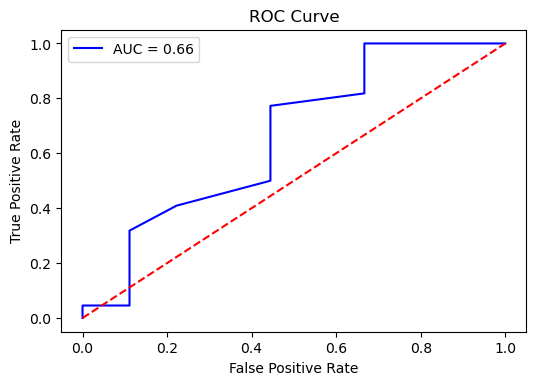

In [49]:
# the area under the curve
fpr, tpr, thresholds = roc_curve(Y, logisticReg.predict_proba(trend_log_2.reshape(-1,1))[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(dpi=100)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [50]:
# Check the recent Google trend and make recommendation

google = us_indicator_data.loc[:, ['Google_trend_2']]
google_future = google.values[-1] - google.values[-2]
b = np.array([google_future])
Y_recommend = logisticReg.predict(b.reshape(-1,1))
Y_recommend, google_future

(array([1.]), array([5], dtype=int64))

In [51]:
logisticReg.predict_proba(b.reshape(-1,1))

array([[0.24311903, 0.75688097]])